# Actor-Critic Training for Attack-Defense Tree Multi-Agent Environment

This notebook demonstrates the training process for actor-critic agents in the ADT multi-agent environment using reinforcement learning.

## Overview
- **Environment**: Attack-Defense Tree (ADT) multi-agent environment
- **Algorithm**: Actor-Critic with policy gradient
- **Agents**: Attacker and Defender with separate neural networks
- **Framework**: PyTorch + PettingZoo

## Training Process
1. Environment setup and configuration
2. Agent initialization with neural networks
3. Multi-agent training loop with episode collection
4. Performance monitoring and visualization
5. Model saving and evaluation

In [1]:
# Import Required Libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from tqdm.notebook import tqdm

# Import our custom modules
from adt_time_env import AttackDefenseTreeMultiAgentTimeEnv
from adt_actor_critic import ADTAgent, TrainingMetrics

# Set style for better plots
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    # Fallback to older seaborn style if v0_8 not available
    try:
        plt.style.use('seaborn')
    except OSError:
        # Use default matplotlib style if seaborn not available
        plt.style.use('default')
        print("⚠️  Using default matplotlib style (seaborn not available)")

sns.set_palette("husl")

# Consistent random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.7.1+cu126
CUDA available: True


## Environment Setup and Configuration

First, let's create the multi-agent environment and examine its properties.

In [2]:
# Create the environment (using clean environment without problematic wrappers)
print("🌍 Setting up ADT Multi-Agent Environment...")

# Force reload the module to pick up changes
import importlib
import adt_time_env
importlib.reload(adt_time_env)
from adt_time_env import AttackDefenseTreeMultiAgentTimeEnv

try:
    # Create environment directly without wrappers to avoid reset issues
    env = AttackDefenseTreeMultiAgentTimeEnv("envs/adt_nuovo_env.json", render_mode=None)
    print("✅ Environment created successfully (clean, without wrappers)!")
    
    # Environment information
    print(f"\n📊 Environment Information:")
    print(f"Agents: {env.possible_agents}")
    print(f"Action spaces: {env.action_spaces}")
    print(f"Observation spaces: {env.observation_spaces}")
    
    # Reset to get initial observations
    try:
        obs, info = env.reset(seed=42)
        print(f"\n🔍 Initial observation shapes:")
        for agent, observation in obs.items():
            print(f"  {agent}: {observation.shape}")
        print("✅ Environment reset working properly!")
    except Exception as e:
        print(f"⚠️  Reset warning: {e}")
        print("Proceeding with environment dimensions from spaces...")
    
    # Get state and action dimensions
    state_size = env.observation_spaces['attacker'].shape[0]
    attacker_action_size = env.action_spaces['attacker'].n
    defender_action_size = env.action_spaces['defender'].n
    
    print(f"\n🧠 Network Dimensions:")
    print(f"State size: {state_size}")
    print(f"Attacker actions: {attacker_action_size}")
    print(f"Defender actions: {defender_action_size}")
    print(f"State variables: {env.state_vars}")
    print(f"Number of state variables: {len(env.state_vars)}")
    
    # Test a quick episode iteration
    print(f"\n⚙️  Testing environment iteration...")
    try:
        agent_count = 0
        for agent_name in env.agent_iter():
            agent_count += 1
            if agent_count > 2:  # Just test first 2 iterations
                break
            obs, reward, term, trunc, info = env.last()
            print(f"  Agent {agent_name}: obs shape {obs.shape}")
            env.step(0)  # Take a dummy action
        print("✅ Environment iteration working!")
    except Exception as e:
        print(f"⚠️  Iteration warning: {e}")
    
except Exception as e:
    print(f"❌ Error setting up environment: {e}")
    raise

🌍 Setting up ADT Multi-Agent Environment...
✅ Environment created successfully (clean, without wrappers)!

📊 Environment Information:
Agents: ['attacker', 'defender']
Action spaces: {'attacker': Discrete(7), 'defender': Discrete(8)}
Observation spaces: {'attacker': Box([ 0  0  0  0  0  0  0  1  1  1  1  1  1 -1 -1], [ 1  1  2  2  2  2  2  2  2  2  2  2  2 20 20], (15,), int32), 'defender': Box([ 0  0  0  0  0  0  0  1  1  1  1  1  1 -1 -1], [ 1  1  2  2  2  2  2  2  2  2  2  2  2 20 20], (15,), int32)}

🔍 Initial observation shapes:
  attacker: (15,)
  defender: (15,)
✅ Environment reset working properly!

🧠 Network Dimensions:
State size: 15
Attacker actions: 7
Defender actions: 8
State variables: ['DataExfiltration', 'current_player', 'AccesstoMySQL', 'AccesstoExecuteArbitraryCode', 'AccesstoReverseShell', 'AccesstoSensitiveFiles', 'WebReconSuccesful', 'UnencryptedFiles', 'SOCKS5ProxyActive', 'MisconfiguredApache', 'WebserverPubliclyExposed', 'CGIscriptsenabled', 'VulnerableApacheHTT

## Agent Initialization

Create the actor-critic agents for both attacker and defender with appropriate neural network architectures.

In [3]:
# Training hyperparameters
LEARNING_RATE = 3e-4
GAMMA = 0.99
HIDDEN_SIZE = 128
MAX_EPISODES = 10_000
UPDATE_FREQUENCY = 10  # Update policy every N episodes
PRINT_FREQUENCY = 100  # Print stats every N episodes

print("🤖 Initializing Actor-Critic Agents...")

# Create agents
attacker_agent = ADTAgent(
    state_size=state_size,
    action_size=attacker_action_size,
    agent_name='attacker',
    lr=LEARNING_RATE,
    gamma=GAMMA,
    hidden_size=HIDDEN_SIZE
)

defender_agent = ADTAgent(
    state_size=state_size,
    action_size=defender_action_size,
    agent_name='defender',
    lr=LEARNING_RATE,
    gamma=GAMMA,
    hidden_size=HIDDEN_SIZE
)

print(f"✅ Agents initialized!")

# Initialize training metrics
metrics = TrainingMetrics()

print(f"\n📈 Training Configuration:")
print(f"Max Episodes: {MAX_EPISODES}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Discount Factor (γ): {GAMMA}")
print(f"Hidden Layer Size: {HIDDEN_SIZE}")
print(f"Update Frequency: {UPDATE_FREQUENCY} episodes")

🤖 Initializing Actor-Critic Agents...
✅ Agents initialized!

📈 Training Configuration:
Max Episodes: 10000
Learning Rate: 0.0003
Discount Factor (γ): 0.99
Hidden Layer Size: 128
Update Frequency: 10 episodes
✅ Agents initialized!

📈 Training Configuration:
Max Episodes: 10000
Learning Rate: 0.0003
Discount Factor (γ): 0.99
Hidden Layer Size: 128
Update Frequency: 10 episodes


## Training Helper Functions

Define utility functions for the training process.

In [4]:
def run_episode(env, attacker_agent, defender_agent, episode_num, max_steps=50):
    """
    Run a single episode and collect experience for both agents.
    
    Returns:
        dict: Episode statistics including rewards, length, and winner
    """

    obs, info = env.reset()

    episode_data = {
        'attacker_reward': 0,
        'defender_reward': 0,
        'length': 0,
        'winner': None,
        'goal_achieved': False
    }
    
    step_count = 0
    
    # Run episode
    for agent_name in env.agent_iter():
        if step_count >= max_steps:
            break
            
        observation, reward, termination, truncation, info = env.last()
        
        # Update rewards
        episode_data[f'{agent_name}_reward'] += reward
        
        if termination or truncation:
            # Store final transition
            if agent_name == 'attacker':
                attacker_agent.store_transition(
                    state=observation,
                    action=0,  # Dummy action for terminal state
                    reward=reward,
                    log_prob=torch.tensor(0.0),
                    value=torch.tensor(0.0),
                    done=True
                )
            else:
                defender_agent.store_transition(
                    state=observation,
                    action=0,  # Dummy action for terminal state
                    reward=reward,
                    log_prob=torch.tensor(0.0),
                    value=torch.tensor(0.0),
                    done=True
                )
            break
        
        step_count += 1
        episode_data['length'] = step_count
        
        # Get available actions
        available_actions = env.get_available_actions(agent_name)

        if not available_actions:
            # No valid actions - game ends
            env.step(0)
            continue
        
        # Get action from appropriate agent
        if agent_name == 'attacker':
            action, log_prob, value, _ = attacker_agent.get_action(observation.astype(np.float32), available_actions)
            attacker_agent.store_transition(observation, action, reward, log_prob, value, False)
        else:
            action, log_prob, value, _ = defender_agent.get_action(observation.astype(np.float32), available_actions)
            defender_agent.store_transition(observation, action, reward, log_prob, value, False)
        
        # Take action
        env.step(action)
    
    episode_data['goal_achieved'] = env.goal  # Check if goal was achieved
    if episode_data['goal_achieved']:
        episode_data['winner'] = 'attacker'  # Attacker achieved goal
    else:
        episode_data['winner'] = 'defender'  # Defender prevented goal
    
    return episode_data


def print_training_stats(episode, metrics, start_time):
    """Print training statistics."""
    current_time = time.time()
    elapsed_time = current_time - start_time
    
    # Get recent statistics
    recent_stats = metrics.get_recent_stats(window=100)
    
    print(f"\n{'='*80}")
    print(f"EPISODE {episode:4d} | Time: {elapsed_time/60:.1f}m")
    print(f"{'='*80}")
    
    if recent_stats:
        print(f"📊 Last 100 Episodes:")
        print(f"   🔥 Avg Attacker Reward: {recent_stats['avg_attacker_reward']:8.2f}")
        print(f"   🛡️  Avg Defender Reward: {recent_stats['avg_defender_reward']:8.2f}")
        print(f"   📏 Avg Episode Length:  {recent_stats['avg_episode_length']:8.2f} steps")
        print(f"   🏆 Attacker Win Rate:   {recent_stats['attacker_win_rate']:8.2%}")
        print(f"   🏆 Defender Win Rate:   {recent_stats['defender_win_rate']:8.2%}")
    
    # Show recent losses if available
    if len(metrics.attacker_losses['total']) > 0:
        recent_att_loss = np.mean(metrics.attacker_losses['total'][-10:])
        recent_def_loss = np.mean(metrics.defender_losses['total'][-10:])
        print(f"   📉 Recent Attacker Loss: {recent_att_loss:8.4f}")
        print(f"   📉 Recent Defender Loss: {recent_def_loss:8.4f}")


# Create directories for saving models and metrics
os.makedirs('trained_models', exist_ok=True)
os.makedirs('training_logs', exist_ok=True)

print("✅ Training helper functions defined!")
print("📁 Directories created for saving models and logs")

✅ Training helper functions defined!
📁 Directories created for saving models and logs


## Main Training Loop

Execute the main training loop with experience collection and policy updates.

In [5]:
# Main Training Loop
print("🚀 Starting Actor-Critic Training!")
print("="*80)

start_time = time.time()
best_combined_reward = float('-inf')

try:
    for episode in tqdm(range(1, MAX_EPISODES + 1)):
        # Run episode and collect experience
        episode_data = run_episode(env, attacker_agent, defender_agent, episode)
        
        # Log episode data
        metrics.log_episode(episode_data)
        
        # Update policies periodically
        if episode % UPDATE_FREQUENCY == 0:
            # Update attacker policy
            att_losses = attacker_agent.update_policy()
            if att_losses:
                metrics.log_losses('attacker', att_losses)
            
            # Update defender policy
            def_losses = defender_agent.update_policy()
            if def_losses:
                metrics.log_losses('defender', def_losses)
        
        # Print statistics
        if episode % PRINT_FREQUENCY == 0:
            print_training_stats(episode, metrics, start_time)

except KeyboardInterrupt:
    print(f"\n⏹️  Training interrupted by user at episode {episode}")
except Exception as e:
    print(f"\n❌ Training error: {e}")
    raise

finally:
    # Save final models and metrics
    print(f"\n💾 Saving final models and metrics...")
    attacker_agent.save_model('trained_models/attacker_actor_critic.pth')
    defender_agent.save_model('trained_models/defender_actor_critic.pth')
    metrics.save_metrics('training_logs/training_metrics.pkl')
    
    total_time = time.time() - start_time
    print(f"✅ Training completed in {total_time/60:.1f} minutes!")
    print(f"📊 Total episodes: {len(metrics.episode_lengths)}")

🚀 Starting Actor-Critic Training!


  0%|          | 0/10000 [00:00<?, ?it/s]


EPISODE  100 | Time: 0.0m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward:  -962.20
   🛡️  Avg Defender Reward: -3748.10
   📏 Avg Episode Length:     25.96 steps
   🏆 Attacker Win Rate:     80.00%
   🏆 Defender Win Rate:     20.00%
   📉 Recent Attacker Loss:   0.6400
   📉 Recent Defender Loss:   0.6838

EPISODE  200 | Time: 0.1m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward:  -920.70
   🛡️  Avg Defender Reward: -2424.00
   📏 Avg Episode Length:     23.54 steps
   🏆 Attacker Win Rate:     68.00%
   🏆 Defender Win Rate:     32.00%
   📉 Recent Attacker Loss:   0.5222
   📉 Recent Defender Loss:   0.4781

EPISODE  200 | Time: 0.1m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward:  -920.70
   🛡️  Avg Defender Reward: -2424.00
   📏 Avg Episode Length:     23.54 steps
   🏆 Attacker Win Rate:     68.00%
   🏆 Defender Win Rate:     32.00%
   📉 Recent Attacker Loss:   0.5222
   📉 Recent Defender Loss:   0.4781

EPISODE  300 | Time: 0.1m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward:  -876.80
   🛡️  A

## Training Results Visualization

Analyze and visualize the training progress with comprehensive plots.

📊 Generating training visualization...
Training progress plot saved to training_logs/time_training_progress.png
Training progress plot saved to training_logs/time_training_progress.png


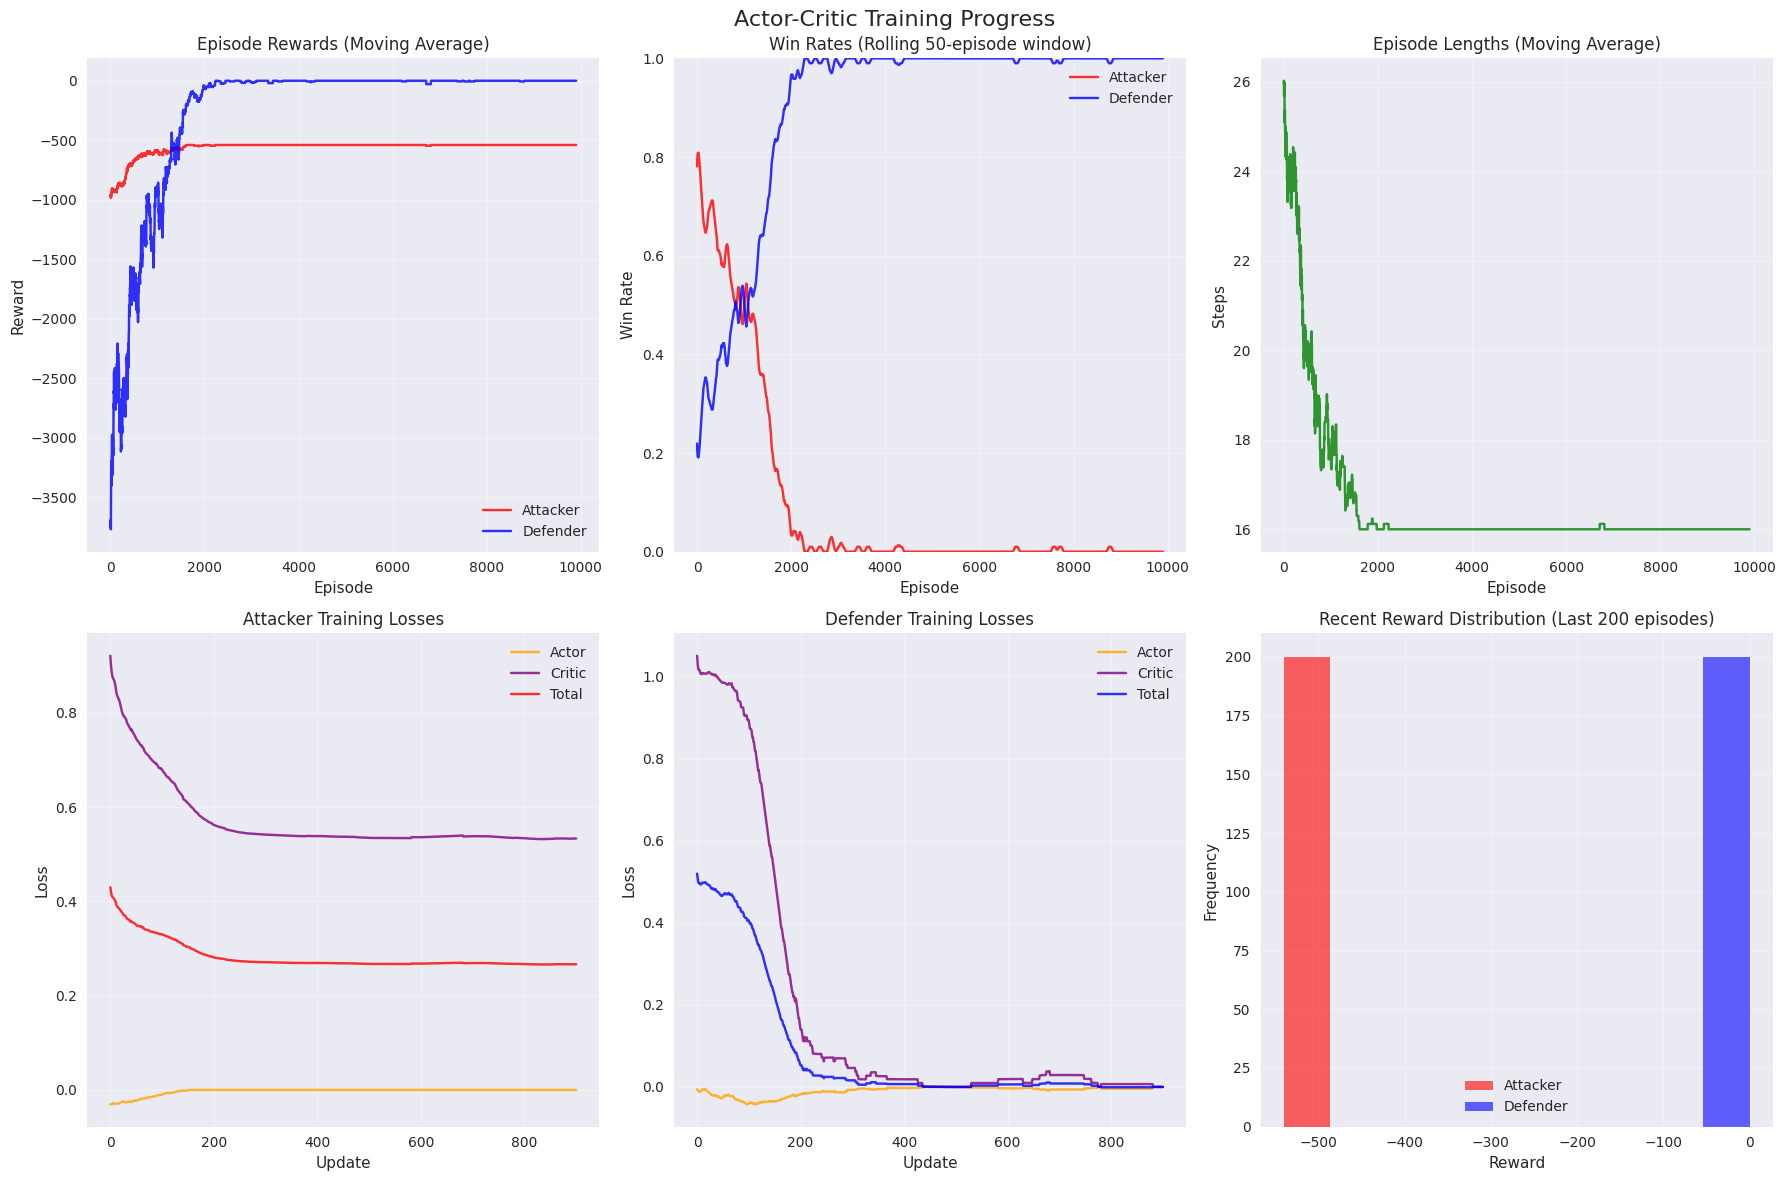


📈 FINAL TRAINING STATISTICS
Total Episodes Completed: 10000
Average Episode Length: 16.60 ± 3.65

🏆 FINAL PERFORMANCE (Last 200 episodes):
Attacker Win Rate: 0.00%
Defender Win Rate: 100.00%
Average Attacker Reward: -540.00
Average Defender Reward: 0.00
Average Episode Length: 16.00 steps

🎯 FINAL TRAINING LOSSES:
Attacker Final Loss: 0.2674
Defender Final Loss: 0.0000


In [6]:
# Plot comprehensive training results
print("📊 Generating training visualization...")

# Create the training progress plot
metrics.plot_training_progress(save_path='training_logs/time_training_progress.png')

# Additional analysis
print(f"\n📈 FINAL TRAINING STATISTICS")
print(f"="*50)

if len(metrics.episode_lengths) > 0:
    total_episodes = len(metrics.episode_lengths)
    
    # Overall statistics
    print(f"Total Episodes Completed: {total_episodes}")
    print(f"Average Episode Length: {np.mean(metrics.episode_lengths):.2f} ± {np.std(metrics.episode_lengths):.2f}")
    
    # Final performance (last 200 episodes)
    final_window = min(200, total_episodes)
    final_stats = metrics.get_recent_stats(final_window)
    
    print(f"\n🏆 FINAL PERFORMANCE (Last {final_window} episodes):")
    print(f"Attacker Win Rate: {final_stats['attacker_win_rate']:.2%}")
    print(f"Defender Win Rate: {final_stats['defender_win_rate']:.2%}")
    print(f"Average Attacker Reward: {final_stats['avg_attacker_reward']:.2f}")
    print(f"Average Defender Reward: {final_stats['avg_defender_reward']:.2f}")
    print(f"Average Episode Length: {final_stats['avg_episode_length']:.2f} steps")
    
    # Training stability analysis
    if len(metrics.attacker_losses['total']) > 10:
        recent_att_loss = np.mean(metrics.attacker_losses['total'][-50:])
        recent_def_loss = np.mean(metrics.defender_losses['total'][-50:])
        print(f"\n🎯 FINAL TRAINING LOSSES:")
        print(f"Attacker Final Loss: {recent_att_loss:.4f}")
        print(f"Defender Final Loss: {recent_def_loss:.4f}")
else:
    print("No training data available for analysis.")

## Model Testing and Evaluation

Test the trained models with a few evaluation games to verify performance.

In [7]:
# Test the trained models
print("🧪 Testing Trained Models")
print("="*50)

def test_trained_models(n_test_games=10):
    """Test the trained models with deterministic policies."""
    print(f"Running {n_test_games} test games with trained models...")
    
    test_results = {
        'attacker_rewards': [],
        'defender_rewards': [],
        'episode_lengths': [],
        'winners': []
    }
    
    for game in range(n_test_games):
        # Handle environment reset with proper error handling
        obs, info = env.reset()
        
        game_rewards = {'attacker': 0, 'defender': 0}
        step_count = 0
        
        for agent_name in env.agent_iter():
            if step_count > 50:  # Max steps limit
                break
                
            observation, reward, termination, truncation, info = env.last()
            game_rewards[agent_name] += reward
            
            if termination or truncation:
                env.step(None)
                break
            
            step_count += 1
            # Get available actions
            try:
                available_actions = env.get_available_actions(agent_name)
            except:
                # If method doesn't exist, use all actions
                if agent_name == 'attacker':
                    available_actions = list(range(6))
                else:
                    available_actions = list(range(7))
            
            if not available_actions:
                env.step(0)
                continue
            
            # Get deterministic action from trained agent
            if agent_name == 'attacker':
                action, _, _, _ = attacker_agent.get_action(observation, available_actions, deterministic=True)
            else:
                action, _, _, _ = defender_agent.get_action(observation, available_actions, deterministic=True)
            
            env.step(action)
        
        # Store results
        test_results['attacker_rewards'].append(game_rewards['attacker'])
        test_results['defender_rewards'].append(game_rewards['defender'])
        test_results['episode_lengths'].append(step_count)
        
        if game_rewards['attacker'] > game_rewards['defender']:
            test_results['winners'].append('attacker')
        elif game_rewards['defender'] > game_rewards['attacker']:
            test_results['winners'].append('defender')
        else:
            test_results['winners'].append('tie')
        
        print(f"Game {game+1:2d}: Att {game_rewards['attacker']:6.1f} | "
              f"Def {game_rewards['defender']:6.1f} | "
              f"Length: {step_count:2d} | "
              f"Winner: {test_results['winners'][-1]}")
    
    return test_results

# Run test games
test_results = test_trained_models(10)

# Analyze test results
print(f"\n🎯 TEST RESULTS SUMMARY:")
print(f"="*30)
print(f"Average Attacker Reward: {np.mean(test_results['attacker_rewards']):.2f}")
print(f"Average Defender Reward: {np.mean(test_results['defender_rewards']):.2f}")
print(f"Average Episode Length: {np.mean(test_results['episode_lengths']):.2f} steps")

attacker_wins = test_results['winners'].count('attacker')
defender_wins = test_results['winners'].count('defender')  
ties = test_results['winners'].count('tie')

print(f"Attacker Wins: {attacker_wins}/{len(test_results['winners'])} ({attacker_wins/len(test_results['winners']):.1%})")
print(f"Defender Wins: {defender_wins}/{len(test_results['winners'])} ({defender_wins/len(test_results['winners']):.1%})")
print(f"Ties: {ties}/{len(test_results['winners'])} ({ties/len(test_results['winners']):.1%})")

print(f"\n✅ Model testing complete!")

🧪 Testing Trained Models
Running 10 test games with trained models...
Game  1: Att -540.0 | Def    0.0 | Length: 16 | Winner: defender
Game  2: Att -540.0 | Def    0.0 | Length: 16 | Winner: defender
Game  3: Att -540.0 | Def    0.0 | Length: 16 | Winner: defender
Game  4: Att -540.0 | Def    0.0 | Length: 16 | Winner: defender
Game  5: Att -540.0 | Def    0.0 | Length: 16 | Winner: defender
Game  6: Att -540.0 | Def    0.0 | Length: 16 | Winner: defender
Game  7: Att -540.0 | Def    0.0 | Length: 16 | Winner: defender
Game  8: Att -540.0 | Def    0.0 | Length: 16 | Winner: defender
Game  9: Att -540.0 | Def    0.0 | Length: 16 | Winner: defender
Game 10: Att -540.0 | Def    0.0 | Length: 16 | Winner: defender

🎯 TEST RESULTS SUMMARY:
Average Attacker Reward: -540.00
Average Defender Reward: 0.00
Average Episode Length: 16.00 steps
Attacker Wins: 0/10 (0.0%)
Defender Wins: 10/10 (100.0%)
Ties: 0/10 (0.0%)

✅ Model testing complete!


In [8]:
# Show a game example with detailed step-by-step information
print("\n📸 Showing an example test game with detailed steps...")

def show_test_game(env, attacker_agent, defender_agent, max_steps=30):
    """Run and visualize a single test game with detailed step-by-step information."""
    
    obs, info = env.reset()

    print("\n🎮 GAME START")
    print("="*50)
    print(f"Initial state: {env.state if hasattr(env, 'state') else 'Unknown'}")
    
    step_count = 0
    done = False
    total_rewards = {'attacker': 0, 'defender': 0}
    
    while not done and step_count < max_steps:
        for agent_name in env.agent_iter():
            observation, reward, termination, truncation, info = env.last()
            
            if termination or truncation:
                print(f"   ⚠️  Game terminated: {termination}, truncated: {truncation}")
                done = True
                break
            
            step_count += 1
            
            # Print step information
            print(f"\n⏱️  STEP {step_count} | Agent: {agent_name}")
            print(f"   Observation: {observation}")
            print(f"   Reward: {reward}")
            total_rewards[agent_name] += reward
            
            # Get available actions
            available_actions = env.get_available_actions(agent_name)
            print(f"   Available actions: {available_actions}")
            
            # Get action from appropriate agent
            if agent_name == 'attacker':
                action, _, _, action_probs = attacker_agent.get_action(observation, available_actions, deterministic=True)
                print(f"   🔴 Attacker chose action: {env.get_action_name(action, agent_name)}")
            else:
                action, _, _, action_probs = defender_agent.get_action(observation, available_actions, deterministic=True)
                print(f"   🔵 Defender chose action: {env.get_action_name(action, agent_name)}")

            # Take action
            env.step(action)
            
            # Print state after action if available
            if hasattr(env, 'state'):
                print(f"   New state: {env.state}")
            
            # Print current cumulative rewards
            print(f"   Cumulative rewards: Attacker: {total_rewards['attacker']}, Defender: {total_rewards['defender']}")
    
    # Game summary
    print("\n🏁 GAME SUMMARY")
    print("="*50)
    print(f"Game ended after {step_count} steps.")
    print(f"Final state: {env.state if hasattr(env, 'state') else 'Unknown'}")
    
    # Determine winner based on final state
    goal_achieved = False
    if hasattr(env, 'state') and isinstance(env.state, dict):
        goal_achieved = env.state.get(env.goal, 0) == 1
    
    if goal_achieved:
        print("🎯 Attacker successfully achieved the goal!")
        winner = "attacker"
    else:
        print("🛡️ Defender successfully prevented the attack!")
        winner = "defender"
    
    print(f"Winner: {winner}")
    print(f"Final rewards: Attacker: {total_rewards['attacker']}, Defender: {total_rewards['defender']}")

# Run the test game with detailed output
show_test_game(env, attacker_agent, defender_agent)



📸 Showing an example test game with detailed steps...

🎮 GAME START
Initial state: {'DataExfiltration': 0, 'current_player': 0, 'AccesstoMySQL': 0, 'AccesstoExecuteArbitraryCode': 0, 'AccesstoReverseShell': 0, 'AccesstoSensitiveFiles': 0, 'WebReconSuccesful': 0, 'UnencryptedFiles': 1, 'SOCKS5ProxyActive': 1, 'MisconfiguredApache': 1, 'WebserverPubliclyExposed': 1, 'CGIscriptsenabled': 1, 'VulnerableApacheHTTPServerVersion': 1}

⏱️  STEP 1 | Agent: attacker
   Observation: [ 0  0  0  0  0  0  0  1  1  1  1  1  1 -1 -1]
   Reward: 0
   Available actions: [5]
   🔴 Attacker chose action: webRecon
   New state: {'DataExfiltration': 0, 'current_player': 0, 'AccesstoMySQL': 0, 'AccesstoExecuteArbitraryCode': 0, 'AccesstoReverseShell': 0, 'AccesstoSensitiveFiles': 0, 'WebReconSuccesful': 0, 'UnencryptedFiles': 1, 'SOCKS5ProxyActive': 1, 'MisconfiguredApache': 1, 'WebserverPubliclyExposed': 1, 'CGIscriptsenabled': 1, 'VulnerableApacheHTTPServerVersion': 1}
   Cumulative rewards: Attacker: 0, D